In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D # 三维数据可视化
import hiddenlayer as hl 
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.utils.data as Data 
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

In [2]:
# # 使用手写体数据，准备训练数据集
# train_data = MNIST(
#     root = './data/MNIST',
#     train = True, # 只使用训练数据集
#     transform = transforms.ToTensor(),
#     download = True
# )

In [3]:
# # 将图像数据转为向量数据
# train_data_x = train_data.data.type(torch.FloatTensor) / 255.0
# train_data_x = train_data_x.reshape(train_data_x.shape[0], -1)
# train_data_y = train_data.targets
# # 定义一个数据加载器
# train_loader = Data.DataLoader(
#     dataset = train_data_x,
#     batch_size = 64,
#     shuffle = True,
#     num_workers = 2 # Windows需要设置为0
# )

In [4]:
import scanpy as sc
data=sc.read_h5ad("new_data.h5ad")
label=data.obs['label'].to_numpy()
newlabel=[]
for i in label:
    if i=="astrocytes_ependymal":
        newlabel.append(0)
    elif i=="endothelial-mural":
        newlabel.append(1)
    elif i=="interneurons":
        newlabel.append(2)
    elif i=="microglia":
        newlabel.append(3)
    elif i=="oligodendrocytes":
        newlabel.append(4)
    elif i=="pyramidal CA1":
        newlabel.append(5)
    else:
        newlabel.append(6)
source_data = data.X
source_label = np.array(newlabel).reshape(773,1)

In [5]:
type(source_data)

numpy.ndarray

In [6]:
data.X.shape

(773, 4576)

In [7]:
train_data=torch.from_numpy(source_data)

In [8]:
train_data.shape

torch.Size([773, 4576])

In [9]:
type(train_data)

torch.Tensor

In [10]:
train_label=torch.from_numpy(np.array(newlabel))

In [11]:
train_label.shape

torch.Size([773])

In [12]:
type(train_label)

torch.Tensor

In [13]:
# 将图像数据转为向量数据
train_data=torch.from_numpy(source_data)
train_label=torch.from_numpy(np.array(newlabel))
# 定义一个数据加载器
train_loader = Data.DataLoader(
    dataset = train_data,
    batch_size = 64,
    shuffle = True,
    num_workers = 2 # Windows需要设置为0
)

In [14]:
# 使用手写体数据，准备训练数据集
test=sc.read_h5ad("new_data.h5ad")
label_1=test.obs['label'].to_numpy()
newlabel_1=[]
for i in label_1:
    if i=="astrocytes_ependymal":
        newlabel_1.append(0)
    elif i=="endothelial-mural":
        newlabel_1.append(1)
    elif i=="interneurons":
        newlabel_1.append(2)
    elif i=="microglia":
        newlabel_1.append(3)
    elif i=="oligodendrocytes":
        newlabel_1.append(4)
    elif i=="pyramidal CA1":
        newlabel_1.append(5)
    else:
        newlabel_1.append(6)
source_data_1 = test.X

In [15]:
# 将图像数据转为向量数据
test_data=torch.from_numpy(source_data_1)
test_label=torch.from_numpy(np.array(newlabel_1))
print('训练数据集:', train_data.shape)
print('测试数据集:', test_data.shape)

训练数据集: torch.Size([773, 4576])
测试数据集: torch.Size([773, 4576])


In [16]:
class EnDecoder(nn.Module):
    def __init__(self):
        super(EnDecoder, self).__init__()
        # 定义Encoder
        self.Encoder = nn.Sequential(
            nn.Linear(4576, 512),
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 3),
            nn.Tanh(),
        )
        # 定义Decoder
        self.Decoder = nn.Sequential(
            nn.Linear(3, 128),
            nn.Tanh(),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Linear(256, 512),
            nn.Tanh(),
            nn.Linear(512, 4576),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        encoder = self.Encoder(x)
        decoder = self.Decoder(encoder)
        return encoder, decoder

In [17]:
# 模型加载选择GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
# 定义自编码网络edmodel
myedmodel = EnDecoder().to(device)

In [18]:
from torchsummary import summary

summary(myedmodel, input_size=(1, 4576))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]       2,343,424
              Tanh-2               [-1, 1, 512]               0
            Linear-3               [-1, 1, 256]         131,328
              Tanh-4               [-1, 1, 256]               0
            Linear-5               [-1, 1, 128]          32,896
              Tanh-6               [-1, 1, 128]               0
            Linear-7                 [-1, 1, 3]             387
              Tanh-8                 [-1, 1, 3]               0
            Linear-9               [-1, 1, 128]             512
             Tanh-10               [-1, 1, 128]               0
           Linear-11               [-1, 1, 256]          33,024
             Tanh-12               [-1, 1, 256]               0
           Linear-13               [-1, 1, 512]         131,584
             Tanh-14               [-1,

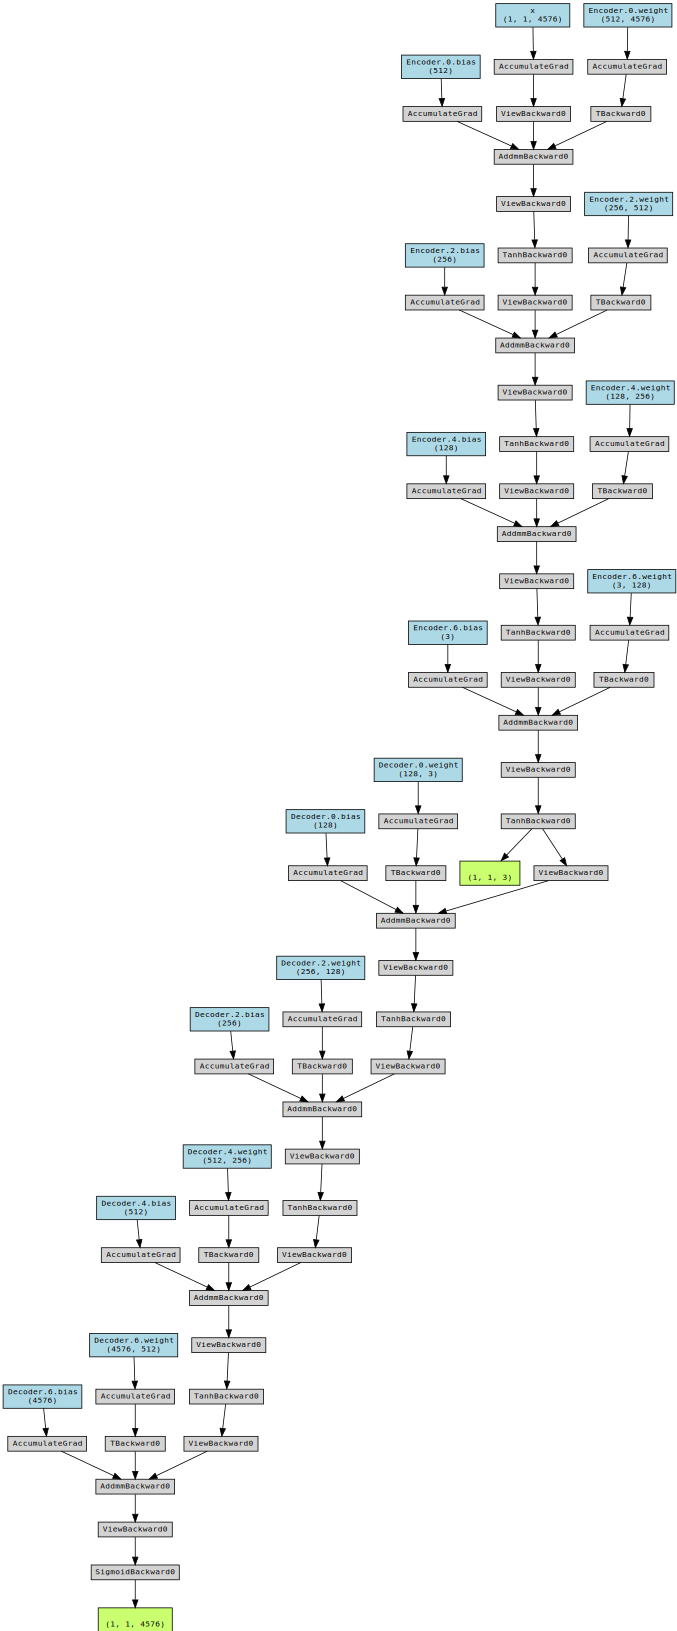

In [19]:
# 输出网络结构
from torchviz import make_dot

x = torch.randn(1, 1, 4576).requires_grad_(True)
y = myedmodel(x.to(device))
myEDNet_vis = make_dot(y, params=dict(list(myedmodel.named_parameters()) + [('x', x)]))
myEDNet_vis

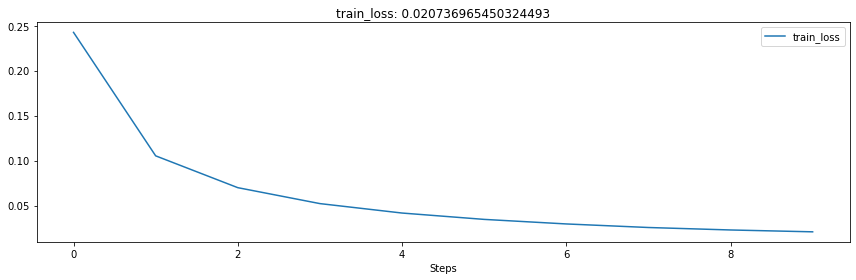

In [20]:
optimizer = optim.Adam(myedmodel.parameters(), lr = 0.003)
loss_func = nn.MSELoss().to(device)
# 记录训练过程的指标
historyl = hl.History()
# 使用Canvas进行可视化
canvasl = hl.Canvas()
train_num = 0
val_num = 0
# 对模型迭代训练
for epoch in range(10):
    train_loss_epoch = 0
    # 对训练数据的加载器进行迭代计算
    for step, b_x in enumerate(train_loader):
        # 使用每个batch进行训练模型
        b_x = b_x.to(device)
        _, output = myedmodel(b_x) # 前向传递输出
        loss = loss_func(output, b_x) # 均方根误差
        optimizer.zero_grad() # 每个迭代步的梯度初始化为0
        loss.backward() # 损失的后向传播，计算梯度
        optimizer.step() # 使用梯度进行优化
        train_loss_epoch += loss.item() * b_x.size(0)
        train_num = train_num + b_x.size(0)
    # 计算一个epoch的损失
    train_loss = train_loss_epoch / train_num
    # 保存每个epoch上的输出loss
    historyl.log(epoch, train_loss = train_loss)
    # 可视网络训练的过程
    with canvasl:
        canvasl.draw_plot(historyl['train_loss'])

In [21]:
# 预测测试集前100张图像的输出
myedmodel.eval()
_, test_decoder = myedmodel(test_data[0: 100, :].to(device))

In [22]:
test_decoder.shape

torch.Size([100, 4576])

In [24]:
test_decoder

tensor([[1.1124e-03, 1.2676e-01, 1.9480e-01,  ..., 4.2851e-06, 1.4501e-05,
         3.0766e-06],
        [1.1079e-03, 1.2617e-01, 1.9437e-01,  ..., 4.2807e-06, 1.4489e-05,
         3.0735e-06],
        [1.1112e-03, 1.2660e-01, 1.9468e-01,  ..., 4.2840e-06, 1.4498e-05,
         3.0757e-06],
        ...,
        [1.1033e-03, 1.2557e-01, 1.9392e-01,  ..., 4.2763e-06, 1.4477e-05,
         3.0703e-06],
        [1.1056e-03, 1.2588e-01, 1.9415e-01,  ..., 4.2786e-06, 1.4484e-05,
         3.0719e-06],
        [1.1040e-03, 1.2567e-01, 1.9399e-01,  ..., 4.2770e-06, 1.4479e-05,
         3.0708e-06]], grad_fn=<SigmoidBackward0>)

In [25]:
test_data

tensor([[0.7037, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.7583, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.1762, 1.1762, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [26]:
# 获取前500个样本的自编码后的特征，并对数据进行可视化
myedmodel.eval()
TEST_num = 500
test_encoder, _ = myedmodel(test_data[0: TEST_num, :].to(device))
print('test_encoder.shape:', test_encoder.shape)

test_encoder.shape: torch.Size([500, 3])


In [27]:
# 自编码降维后的特征训练集和测试集
train_ed_x, _ = myedmodel(train_data.to(device))
train_ed_x = train_ed_x.cpu().data.numpy()
train_y = train_label.data.numpy()
test_ed_x, _ = myedmodel(test_data.to(device))
test_ed_x = test_ed_x.cpu().data.numpy()
test_y = test_label.data.numpy()

In [28]:
# PCA降维获得训练集和测试集的3个主成分
pcamodel = PCA(n_components = 5, random_state = 10)
train_pca_x = pcamodel.fit_transform(train_data.data.numpy())
test_pca_x = pcamodel.transform(test_data.numpy())
print(train_pca_x.shape)

(773, 5)


In [29]:
# 使用自编码数据建立分类器，训练和预测
encodersvc = SVC(kernel = 'rbf', random_state = 12345)

In [30]:
encodersvc.fit(train_ed_x, train_y)

SVC(random_state=12345)

In [31]:
edsvc_pre = encodersvc.predict(test_ed_x)

In [32]:
print(classification_report(test_y, edsvc_pre))
print('模型精度', accuracy_score(test_y, edsvc_pre))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       157
           1       0.00      0.00      0.00       186
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00        73
           4       0.44      1.00      0.61       337
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00         5

    accuracy                           0.44       773
   macro avg       0.06      0.14      0.09       773
weighted avg       0.19      0.44      0.26       773

模型精度 0.4359637774902975


D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
pcasvc = SVC(kernel = 'rbf', random_state = 123)
pcasvc.fit(train_pca_x, train_y)
pcasvc_pre = pcasvc.predict(test_pca_x)
print(classification_report(test_y, pcasvc_pre))
print('模型精度', accuracy_score(test_y, pcasvc_pre))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       157
           1       0.99      0.97      0.98       186
           2       0.00      0.00      0.00         5
           3       0.99      0.99      0.99        73
           4       0.98      0.98      0.98       337
           5       0.50      1.00      0.67        10
           6       0.00      0.00      0.00         5

    accuracy                           0.97       773
   macro avg       0.63      0.70      0.66       773
weighted avg       0.96      0.97      0.96       773

模型精度 0.9676584734799483


D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
test_data

tensor([[0.7037, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.7583, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.1762, 1.1762, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [36]:
test_decoder

tensor([[1.1124e-03, 1.2676e-01, 1.9480e-01,  ..., 4.2851e-06, 1.4501e-05,
         3.0766e-06],
        [1.1079e-03, 1.2617e-01, 1.9437e-01,  ..., 4.2807e-06, 1.4489e-05,
         3.0735e-06],
        [1.1112e-03, 1.2660e-01, 1.9468e-01,  ..., 4.2840e-06, 1.4498e-05,
         3.0757e-06],
        ...,
        [1.1033e-03, 1.2557e-01, 1.9392e-01,  ..., 4.2763e-06, 1.4477e-05,
         3.0703e-06],
        [1.1056e-03, 1.2588e-01, 1.9415e-01,  ..., 4.2786e-06, 1.4484e-05,
         3.0719e-06],
        [1.1040e-03, 1.2567e-01, 1.9399e-01,  ..., 4.2770e-06, 1.4479e-05,
         3.0708e-06]], grad_fn=<SigmoidBackward0>)

In [46]:
pcasvc_pre

array([5, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4,
       4, 4, 4, 0, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4,

In [47]:
test_pca_x

array([[-3.44854   , -3.0562546 , -2.3077867 , 11.5929785 , -6.2111053 ],
       [-3.148087  , -3.4793859 , -2.4929605 ,  8.32391   , -4.418627  ],
       [-3.4927673 , -2.7125962 , -2.510366  , 11.913454  , -5.7870927 ],
       ...,
       [ 2.4127593 , -0.27803528, -3.6090548 , 15.102227  ,  6.384464  ],
       [-1.4047539 ,  9.388312  , -1.2633969 ,  1.1920725 , 15.588483  ],
       [ 9.880019  ,  5.9543447 , -3.940105  , -0.786478  ,  6.6804786 ]],
      dtype=float32)

In [50]:
pd.DataFrame(pcasvc_pre).to_csv('pcasvc_pre.csv', index=False)
pd.DataFrame(test_pca_x).to_csv('test_pca_x.csv', index=False)

In [ ]:
pd.DataFrame(test_decoder.numpy()).to_csv('test_decoder.csv', index=False)
pd.DataFrame(test_data.numpy()).to_csv('test_data.csv', index=False)
pd.DataFrame(test_label.numpy()).to_csv('test_label.csv', index=False)